> Este ntb testa a utilização do avaliadores implementados em `pyAutoSummarizer` 

# Evaluators Validation Notebook 
Este notebook demonstra, **cálculo a cálculo**, como devem ser obtidas as
pontuações de cada métrica usada em *pyAutoSummarizer* **sem** importar as
classes prontas de `evaluation/`.  


In [1]:
## Dependências essenciais
# !pip -q install rouge-score nltk sentence-transformers gensim
import warnings, nltk
warnings.filterwarnings('ignore', category=FutureWarning)
nltk.download('punkt_tab', quiet=True) # Baixa o PunktTokenizer

True

## 1  Lexical

> Precisaremos aplicar ``StopWords`` + ``Stemming`` antes de aplicar cada Evaluator Lexical

> Nele, precisaremos flaguear se as aplicações serão em ``PT`` ou ``EN``, únicas transformações disponíveis inicialmente

**Exemplo**
- Referência: “Eu amo estudar na Universidade Federal Fluminense.”  
- Resumo gerado: “Eu adoro estudar na UFF.”

Calcularemos três métricas tradicionais:
1. ROUGE‑1 F1  
2. ROUGE‑L F1  
3. BLEU‑4  
4. METEOR

📝 **Formato esperado** — um `dict` com quatro chaves (`rouge1_f1`,
`rougeL_f1`, `bleu4`, `meteor`) e valores `float ∈ [0,1]`.

In [2]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

reference = "Eu amo estudar na Universidade Federal Fluminense."
generated  = "Eu adoro estudar na UFF."

# ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True) 
# Aqui é aplicado um stemmer em inglês, 
# Para aplicarmos nosso caso de texto ptbr, preciaríamos usar o RSLPSTemmer 
rouge_scores = scorer.score(reference, generated)
lexical = {
    'rouge1_f1': rouge_scores['rouge1'].fmeasure,
    'rougeL_f1': rouge_scores['rougeL'].fmeasure,
}

# BLEU‑4
chen = SmoothingFunction()
lexical['bleu4'] = sentence_bleu(
    [reference.split()], # Token de Reference 
    generated.split(), # Token de Generado
    weights=(0.25,0.25,0.25,0.25), # Pesos para BLEU-4 (4 pesos pois Bleu4)
    smoothing_function=chen.method1 # Evita que o produto vire 0
)

# METEOR
lexical['meteor'] = meteor_score([reference.split()], generated.split())

print(lexical)


{'rouge1_f1': 0.5, 'rougeL_f1': 0.5, 'bleu4': 0.08428828344718171, 'meteor': 0.3758169934640523}


### Tratando Dados para uma Avaliação Correta (PTBR)

> Precisamos remover ``stopwords`` e ``stemming`` para ter uma avaliação mais fiel a realidade

In [3]:
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer, SnowballStemmer
nltk.download('rslp',quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download("punkt", quiet=True)




def preprocess_text(text: str,LANGUAGE='pt') -> str:
    if LANGUAGE == "pt":
        _STOP_SET  = set(stopwords.words("portuguese"))
        _STEMMER   = RSLPStemmer()
        _TOKEN_LANG = "portuguese"
    else:                          # english
        _STOP_SET  = set(stopwords.words("english"))
        # Porter é o mais leve; Snowball costuma ser ligeiramente melhor
        _STEMMER   = SnowballStemmer("english")
        _TOKEN_LANG = "english"
    

    def stemming(generated):
        tokens = [_STEMMER.stem(w) for w in generated.split()]
        texto_stemmed = " ".join(tokens)
        return texto_stemmed

    def remove_stopwords(text: str) -> str:
        return " ".join(
            w for w in word_tokenize(text, language=_TOKEN_LANG)
            if w.lower() not in _STOP_SET
        )

    def remove_ruido(texto: str) -> str:
        _URLS_HASHTAGS_MENCOES = re.compile(r'https?://\S+|www\.\S+|[@#]\w+', flags=re.UNICODE)
        _DIGITOS                = re.compile(r'\d+', flags=re.UNICODE)
        _PONTUACAO_E_SIMBOLOS   = re.compile(r'[^A-Za-zÀ-ÖØ-öø-ÿ\s]', flags=re.UNICODE)
        _ESPACOS                = re.compile(r'\s+', flags=re.UNICODE)

        # 1) URLs, hashtags, @menções
        texto = _URLS_HASHTAGS_MENCOES.sub(' ', texto)

        # 2) Dígitos
        texto = _DIGITOS.sub(' ', texto)

        # 3) Pontuação e símbolos 
        texto = _PONTUACAO_E_SIMBOLOS.sub(' ', texto)

        # 4) Espaços múltiplos
        texto = _ESPACOS.sub(' ', texto).strip()

        # 7. Caixa baixa (consistência)
        return texto.lower()

    text = remove_ruido(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [4]:
reference = "A quick brown fox jumps over the lazy dog."
generated  = "A fast brown fox leaps over a lazy dog."
preprocess_text(reference,LANGUAGE='english')

'quick brown fox jump lazi dog'

In [5]:
reference = "Eu amo estudar na Universidade Federal Fluminense."
generated  = "Eu adoro estudar na UFF."
reference_preprocessed = preprocess_text(reference)
generated_preprocessed  = preprocess_text(generated)
# ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True) 
# Aqui é aplicado um stemmer em inglês, 
# Para aplicarmos nosso caso de texto ptbr, preciaríamos usar o RSLPSTemmer 
rouge_scores = scorer.score(reference_preprocessed, generated_preprocessed)
lexical = {
    'rouge1_f1': rouge_scores['rouge1'].fmeasure,
    'rougeL_f1': rouge_scores['rougeL'].fmeasure,
}

# BLEU‑4
chen = SmoothingFunction()
lexical['bleu4'] = sentence_bleu(
    [reference_preprocessed.split()], # Token de Reference 
    generated_preprocessed.split(), # Token de Generado
    weights=(0.25,0.25,0.25,0.25), # Pesos para BLEU-4 (4 pesos pois Bleu4)
    smoothing_function=chen.method1 # Evita que o produto vire 0
)

# METEOR
lexical['meteor'] = meteor_score([reference_preprocessed.split()], generated_preprocessed.split())

In [6]:
print(reference_preprocessed,generated_preprocessed,lexical)

amo estud univers feder flumin ador estud uff {'rouge1_f1': 0.25, 'rougeL_f1': 0.25, 'bleu4': 0.05833544737207805, 'meteor': 0.10416666666666666}


## 2  Semantic

Agora mediremos similaridade de significado usando **Sentence‑BERT** . Escolhemos uma frase de exemplo em inglês
porque os modelos pré‑treinados são mais robustos nesse idioma.

### Sentence BERT

> Faz sentido aplicar para parágrafos completos ? Deveria quebrar por sentenças ?

* Podemos gerar um embedding represetnando as senteças e comparar entre si
* Podemos considerar tudo um só sentença 

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

# Two lists of sentences
sentences1 = [
    "The new movie is awesome",
    "The cat sits outside",
    "A man is playing guitar",
]

sentences2 = [
    "The dog plays in the garden",
    "The new movie is so great",
    "A woman watches TV",
]

# Compute embeddings for both lists
embeddings1 = model.encode(sentences1)
embeddings2 = model.encode(sentences2)

# Compute cosine similarities
similarities = model.similarity(embeddings1, embeddings2)

# Output the pairs with their score
for idx_i, sentence1 in enumerate(sentences1):
    print(sentence1)
    for idx_j, sentence2 in enumerate(sentences2):
        print(f" - {sentence2: <30}: {similarities[idx_i][idx_j]:.4f}")

### BERT Score 

**Representação de Tokens:** 
    O BERTScore utiliza embeddings contextuais (provenientes de modelos pré-treinados como BERT, RoBERTa, XLNet ou XLM) para representar os tokens nas sentenças de entrada. A vantagem desses embeddings é que eles geram representações vetoriais diferentes para a mesma palavra em sentenças distintas, dependendo do contexto circundante.

**Medida de Similaridade:** 
    A similaridade entre um token $x_i$ da referência e um token $\hat{x}_j$ da candidata é calculada pela similaridade de cosseno entre seus respectivos vetores de embedding. Essa abordagem oferece uma medida de similaridade "suave", superando a necessidade de correspondência exata de strings.

**Correspondência Greedy:** Para calcular a precisão e o recall, o BERTScore emprega uma estratégia de correspondência gulosa (greedy matching). Isso significa que cada token é correspondido ao token mais similar na outra sentença para maximizar a pontuação de similaridade.

**Cálculo das Pontuações (Precision, Recall, F1):**

> Recall (R_BERT): É a média das similaridades de cosseno máximas, onde cada token da referência é correspondido ao token mais similar na candidata 

> Precision (P_BERT): É a média das similaridades de cosseno máximas, onde cada token da candidata é correspondido ao token mais similar na referência.

> F1 (F_BERT): É a média harmônica da Precisão e do Recall. De forma geral, a recomendação é usar F1, pois ele se mostra mais confiável em diversos cenários.

In [8]:
import bert_score
reference = "A quick brown banana jumps over the lazy dog."
generated  = "A fast brown fox leaps over a lazy dog."
lang = 'en'  # Define the language for BERTScore
P, R, F1 = bert_score.score([generated], [reference], lang=lang,
                             rescale_with_baseline=True,
                             idf=False)

Downloading: 100%|██████████| 25.0/25.0 [00:00<00:00, 25.0kB/s]
Downloading: 100%|██████████| 482/482 [00:00<00:00, 317kB/s]
Downloading: 100%|██████████| 899k/899k [00:00<00:00, 7.63MB/s]
Downloading: 100%|██████████| 456k/456k [00:00<00:00, 3.05MB/s]
Downloading: 100%|██████████| 1.36M/1.36M [00:00<00:00, 11.1MB/s]
Downloading: 100%|██████████| 1.43G/1.43G [00:31<00:00, 45.7MB/s]
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initial

https://github.com/Tiiiger/bert_score#readme

Pontos Relevantes:

* Ponderação de Importância (IDF)
> Para dar mais peso a palavras raras que são mais indicativas de similaridade semântica, o BERTScore permite a incorporação de pesos IDF (Inverse Document Frequency), calculados a partir do corpus de generated
* Reescalonamento de Linha de Base

In [9]:
print(P,R,F1)

tensor([0.6879]) tensor([0.6744]) tensor([0.6816])


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


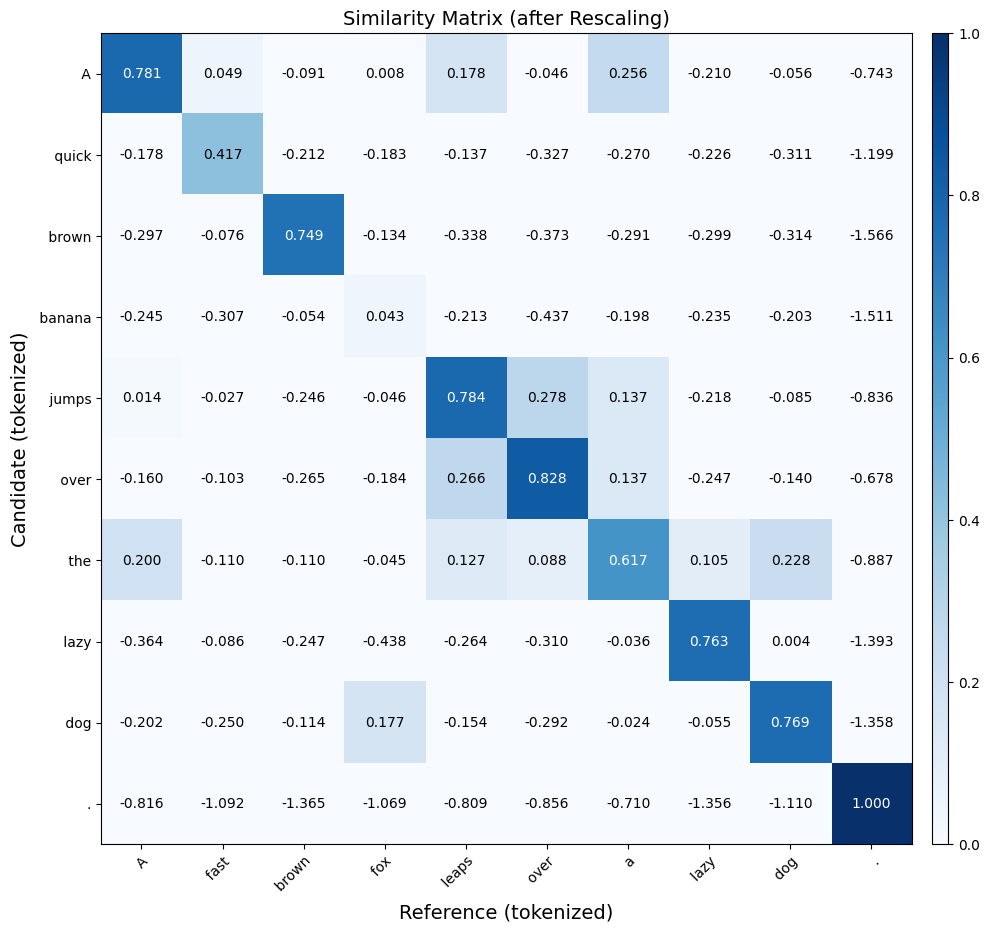

In [ ]:
from bert_score import plot_example
plot_example(reference, generated, lang="en",rescale_with_baseline=False)


## 3  Factual  
*(métricas serão adicionadas futuramente)*

In [2]:
!pip -q install --upgrade transformers torch

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch, textwrap

MODEL_NAME = "manueldeprada/FactCC"  # modelo hospedado no HuggingFace Hub

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

label_map = model.config.id2label  # {0: 'CORRECT', 1: 'INCORRECT'}

c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
print(label_map)

{0: 'CORRECT', 1: 'INCORRECT'}


In [2]:
def factcc_predict(source: str, summary: str, max_length: int = 512):
    encoded = tokenizer(source,
                        summary,
                        truncation='only_first',
                        padding='max_length',
                        # max_length=max_length,
                        return_tensors='pt')
    with torch.no_grad():
        logits = model(**encoded).logits
        probs = torch.softmax(logits, dim=-1)[0]
        label_id = torch.argmax(probs).item()
    return label_map[label_id], probs[label_id].item()

In [3]:
fonte = textwrap.dedent(
"""
    The US has \"passed the peak\" on new coronavirus cases, the White House reported.
    They predict that some states would reopen this month.
    The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths,
    the highest for any country in the world.""")

resumo_correto = "The US has more than 630,000 Covid‑19 cases and over 30,000 deaths, but officials say the country has likely passed the infection peak."
resumo_incorreto = "The pandemic has almost not affected the US."

for r in [resumo_correto, resumo_incorreto]:
    label, score = factcc_predict(fonte, r)
    print(f"Resumo: {r}\\n→ {label}  (confiança: {score:.3f})")

Resumo: The US has more than 630,000 Covid‑19 cases and over 30,000 deaths, but officials say the country has likely passed the infection peak.\n→ CORRECT  (confiança: 0.530)
Resumo: The pandemic has almost not affected the US.\n→ INCORRECT  (confiança: 0.998)


> Testando nos dados fornecidos

In [8]:
from pyAutoSummarizer.base.evaluation.factual import FactCCEvaluator
from pyAutoSummarizer.base.evaluation.base import get_summary_evaluation

factcc_evaluator = FactCCEvaluator(signed=False)   # ou True, se preferir


In [9]:
fonte = textwrap.dedent(
"""
    The US has \"passed the peak\" on new coronavirus cases, the White House reported.
    They predict that some states would reopen this month.
    The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths,
    the highest for any country in the world.""")

resumo_correto = "The US has more than 630,000 Covid‑19 cases and over 30,000 deaths, but officials say the country has likely passed the infection peak."
scores = get_summary_evaluation(
    fonte,
    resumo_correto,
    evaluators=[factcc_evaluator]
)

In [10]:
scores

{'factcc_score': 0.529938280582428, 'factcc_label': 'CORRECT'}

In [11]:
import pandas as pd

df = pd.read_csv("C:\\Users\\thiago.ouverney\\Projetos\\pyAutoSummarizer\\data\\model_annotations_merged.csv")

In [15]:
fonte = textwrap.dedent(df.loc[0,"content"])
fonte

"Paul Merson has restarted his row with Andros Townsend after the Tottenham midfielder was brought on with only seven minutes remaining in his team's 0-0 draw with Burnley on Sunday.\n\n'Just been watching the game, did you miss the coach? #RubberDub #7minutes,' Merson put on Twitter.\n\nMerson initially angered Townsend for writing in his Sky Sports column that 'if Andros Townsend can get in (the England team) then it opens it up to anybody.'\n\nPaul Merson had another dig at Andros Townsend after his appearance for Tottenham against Burnley\n\nTownsend was brought on in the 83rd minute for Tottenham as they drew 0-0 against Burnley\n\nAndros Townsend scores England's equaliser in their 1-1 friendly draw with Italy in Turin on Tuesday night\n\nThe former Arsenal man was proven wrong when Townsend hit a stunning equaliser for England against Italy and he duly admitted his mistake.\n\n'It's not as though I was watching hoping he wouldn't score for England, I'm genuinely pleased for him 

In [24]:
resumo = df.loc[0,'decoded']
resumo_correto = df.loc[0,'references']
eval(resumo_correto)[0]

"Andros Townsend an 83rd minute sub in Tottenham's draw with Burnley. He was unable to find a winner as the game ended without a goal. Townsend had clashed with Paul Merson last week over England call-up."

In [30]:
resumo_correto = df.loc[10,'references']
for i in range(11):
    scores = get_summary_evaluation(
        textwrap.dedent(df.loc[0,"content"]),
        eval(resumo_correto)[i],
        evaluators=[factcc_evaluator]
    )
    print(f"Scores for summary {i}: {scores}")

Scores for summary 0: {'factcc_score': 0.9997658133506775, 'factcc_label': 'CORRECT'}
Scores for summary 1: {'factcc_score': 0.005119919776916504, 'factcc_label': 'INCORRECT'}
Scores for summary 2: {'factcc_score': 0.9331925511360168, 'factcc_label': 'CORRECT'}
Scores for summary 3: {'factcc_score': 0.024936139583587646, 'factcc_label': 'INCORRECT'}
Scores for summary 4: {'factcc_score': 0.9941294193267822, 'factcc_label': 'CORRECT'}
Scores for summary 5: {'factcc_score': 0.1509883999824524, 'factcc_label': 'INCORRECT'}
Scores for summary 6: {'factcc_score': 0.605004072189331, 'factcc_label': 'CORRECT'}
Scores for summary 7: {'factcc_score': 0.00023788213729858398, 'factcc_label': 'INCORRECT'}
Scores for summary 8: {'factcc_score': 0.2600637674331665, 'factcc_label': 'INCORRECT'}
Scores for summary 9: {'factcc_score': 0.0033246278762817383, 'factcc_label': 'INCORRECT'}
Scores for summary 10: {'factcc_score': 0.0035320520401000977, 'factcc_label': 'INCORRECT'}


In [26]:
scores

{'factcc_score': 0.9997658133506775, 'factcc_label': 'CORRECT'}